In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.lines  as mlines
import sys
import json
import torch


from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
from src.mace.neuralODE    import Solver
import src.mace.plotting     as pl
from src.mace.loss         import Loss_analyse


sys.path.append('/STER/silkem/ChemTorch/src')
import rates as rate
## get species
specs, parnt, convs = rate.read_specs_file('C', 16)
specs_dict = dict()
idx_specs  = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i
    idx_specs[i] = specs[i]

%load_ext autoreload
%autoreload 2

### Functions

In [10]:
### OLD FUNCTIONS ###



def load_loss_old(loc, type):
    loss = {'total_loss'       : np.load(loc+type+'/total_loss.npy'),
            'total_mse_loss'   : np.load(loc+type+'/total_mse_loss.npy'),
            'total_rel_loss'   : np.load(loc+type+'/total_rel_loss.npy'),
            'idv_mse_loss'     : np.load(loc+type+'/idv_mse_loss.npy'),
            'idv_rel_loss'     : np.load(loc+type+'/idv_rel_loss.npy')
    }
    return loss



def load_model_old(loc, meta, epoch, sepr):
    cuda   = False
    DEVICE = torch.device("cuda" if cuda else "cpu")
    model = Solver(p_dim=4,z_dim = meta['z_dim'], n_dim=466, DEVICE = DEVICE)

    if sepr == True:
        file = 'nn/nn_'+str(epoch)+'.0.pt'
    else:
        file = 'nn/nn.pt'

    model.load_state_dict(torch.load(loc+file))

    return model

def load_all_old(outloc, dirname, sepr = False):
    loc   = outloc+dirname+'/'

    ## loading losses
    trainloss = load_loss_old(loc,'train')
    testloss  = load_loss_old(loc,'test')

    status = {'train': np.load(loc+'train/status.npy'),
              'test' : np.load(loc+'test/status.npy')}

    ## loading meta file
    with open(loc+'/meta.json', 'r') as f:
        meta=f.read()
    meta  = json.loads(meta)

    ## loading torch model
    model = load_model_old(loc,meta, '', sepr)

    return meta, model, trainloss, testloss, status



In [3]:
### LOADING TRAINED MODEL ###


def load_model(loc, meta, epoch, sepr):
    cuda   = False
    DEVICE = torch.device("cuda" if cuda else "cpu")
    model = Solver(p_dim=4,z_dim = meta['z_dim'], n_dim=466, DEVICE = DEVICE)

    if sepr == True:
        file = 'nn/nn'+str(epoch)+'.pt'
    else:
        file = 'nn/nn.pt'

    model.load_state_dict(torch.load(loc+file))

    return model

def load_all(outloc, dirname, sepr = False):
    loc   = outloc+dirname+'/'

    ## loading meta file
    with open(loc+'/meta.json', 'r') as f:
        meta=f.read()
    meta  = json.loads(meta)

    ## loading losses
    trainloss = Loss_analyse()
    trainloss.load(loc, 'train', meta)
    testloss  = Loss_analyse()
    testloss.load(loc, 'test', meta)

    ## loading torch model
    model = load_model(loc,meta, '', sepr)

    model.set_status(np.load(loc+'train/status.npy'), 'train')
    model.set_status(np.load(loc+'test/status.npy'), 'test')

    return meta, model, trainloss, testloss



In [4]:
### PLOTTING ###

def plot_loss(train, test, log = True, ylim = True, limits = None, notest = False):

    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    lw = 1
    a = 0.8

    if not notest:
        ## ------------ VALIDATING -----------
        ## total loss
        ax1.plot(test.get_tot_loss(), ls = '-', marker = 'None', lw = lw, c='maroon')
        ## mse loss
        ax1.plot(test.get_loss('mse'), ls = '-', marker = 'x', lw = lw, c='lightcoral', alpha = a)
        ## rel loss
        ax1.plot(test.get_loss('rel'), ls = '-.', marker = '1', lw = lw, c='lightcoral', alpha = a)
        ## rel loss
        ax1.plot(test.get_loss('evo'), ls = '--', marker = '.', lw = lw, c='lightcoral', alpha = a)

    ## ------------- TRAINING ------------
    ## total loss
    ax1.plot(train.get_tot_loss(), ls = '-', marker = 'None', lw = lw, c='navy')
    ## mse loss
    ax1.plot(train.get_loss('mse'), ls = '-', marker = 'x', lw = lw, c='lightsteelblue', alpha = a)
    ## rel loss
    ax1.plot(train.get_loss('rel'), ls = '-.', marker = '1', lw = lw, c='lightsteelblue', alpha = a)
    ## rel loss
    ax1.plot(train.get_loss('evo'), ls = '--', marker = '.', lw = lw, c='lightsteelblue', alpha = a)

    

    ## ------------ legend ----------------
    lw2 = 4
    l_train = mlines.Line2D([],[], color = 'blue', ls = '-' , label='train',lw = lw, alpha = 1)
    l_test  = mlines.Line2D([],[], color = 'red' , ls = '-' , label='test' ,lw = lw, alpha = 1)
    l_tot   = mlines.Line2D([],[], color = 'k'   , ls = '-' , label='total',lw = lw, alpha = 1)
    l_mse   = mlines.Line2D([],[], color = 'lightgrey'     , ls = '-' , marker = 'x',label='mse',lw = lw, alpha = 1)
    l_rel   = mlines.Line2D([],[], color = 'lightgrey', ls = '-.', marker = '1',label='rel',lw = lw, alpha = 1)
    l_evo   = mlines.Line2D([],[], color = 'lightgrey', ls = '--' ,marker = '.', label='evo',lw = lw, alpha = 1)
    handles = [l_train, l_test, l_tot, l_mse, l_rel, l_evo]

    ## ------------ settings --------------
    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        if limits == None:
            ax1.set_ylim([1e-2,1e0])
        else:
            ax1.set_ylim(limits)

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles=handles,loc = 'lower right')
    
    plt.tight_layout()

    return fig

def plot_loss_specs(train, specs, log = True, ylim = True, limits = None):
    colors = mpl.cm.viridis(np.linspace(0, 1, len(specs)))

    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_subplot((111))

    ax1.set_title(specs)

    lw = 1
    a = 1

    ## ------------- TRAINING ------------
    leg_mse  = mlines.Line2D([],[], color = 'k' , ls = '-' , marker = 'x' , label='mse' ,lw = lw, alpha = 1)
    leg_rel  = mlines.Line2D([],[], color = 'k' , ls = '--', marker = '.' , label='rel' ,lw = lw, alpha = 1)
    handles = [leg_mse, leg_rel]

    for j, spec in enumerate(specs):
        i = specs_dict[spec]
        ## total loss
        ax1.plot(train.get_idv_loss('mse')[i]+train.get_idv_loss('evo')[i], ls = ':', lw = lw, c=colors[j], alpha = 1)
        ## mse loss
        ax1.plot(train.get_idv_loss('mse')[i], ls = '-', marker = 'x', lw = lw, c=colors[j], alpha = a, label = 'mse '+spec)
        ## rel loss
        ax1.plot(train.get_idv_loss('evo')[i], ls = '--', marker = '.', lw = lw, c=colors[j], alpha = a, label = 'rel '+spec)
        ## legend
        leg  = mlines.Line2D([],[], color = colors[j] , ls = '-' , label=spec ,lw = 4, alpha = 1)
        handles.append(leg)


    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        if limits == None:
            ax1.set_ylim([1e-10,1e1])
        else:
            ax1.set_ylim(limits)


    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles= handles, loc = 'lower right')
    
    plt.tight_layout()

    return fig

def unscale(x, min, max):

    unscaled = x*np.abs(max-min)+min

    return unscaled

### Loading the model and data

In [12]:
outloc  = '/STER/silkem/MACE/models/'

## fast models
dirname = 'test2023-12-05 11:43:40.452759'      ## mse
dirname = 'test2023-12-05 11:45:04.699973'      ## mse + rel
dirname = 'test2023-12-05 11:46:26.156221'     ## mse + evo

meta, model, trainloss, testloss = load_all(outloc, dirname)
meta

{'traindir': 'easy-mace3',
 'lr': 0.001,
 'epochs': 50,
 'z_dim': 10,
 'dt_fract': 0.167,
 'tmax': 599705.1681709265,
 'train_time': 1259.192265033722,
 'overhead': 203.30486178398132,
 'samples': 700,
 'cutoff_abs': 1e-20,
 'done': 'true',
 'norm': {'mse': 1, 'rel': 1, 'evo': 1},
 'fract': {'mse': 100, 'rel': 100, 'evo': 100},
 'losstype': 'mse_evo'}

### Losses

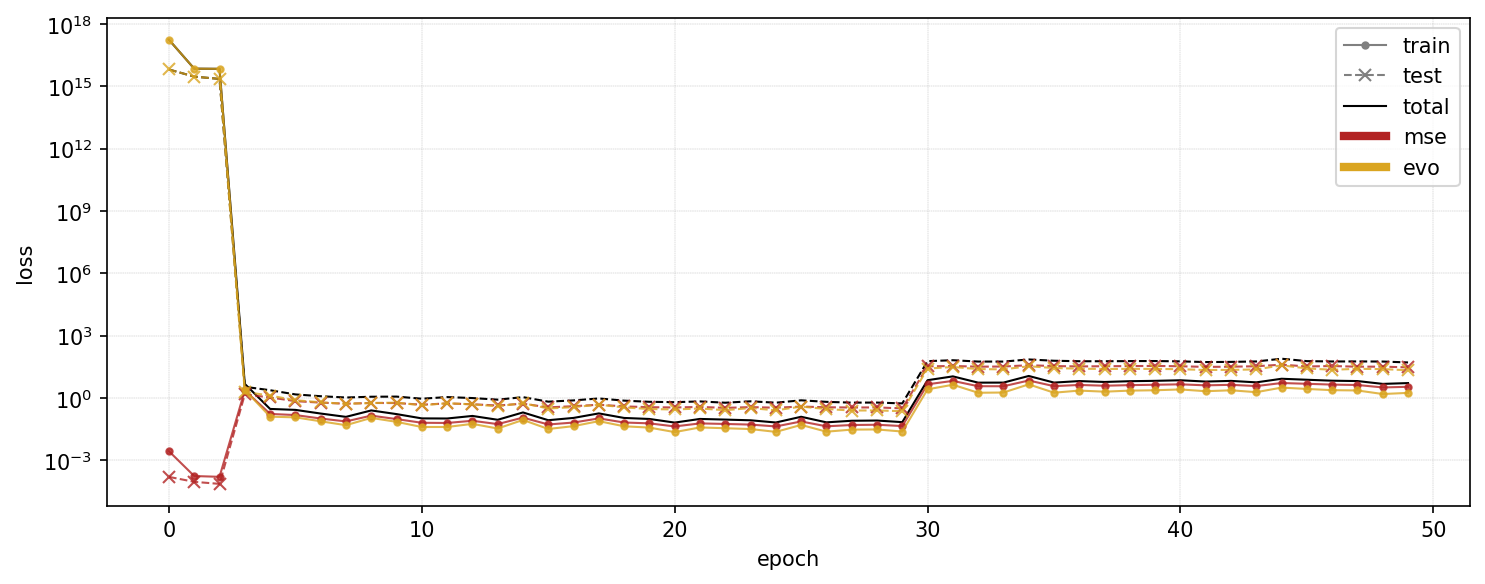

In [13]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = False)#, limits = None, notest = False)

plt.show()

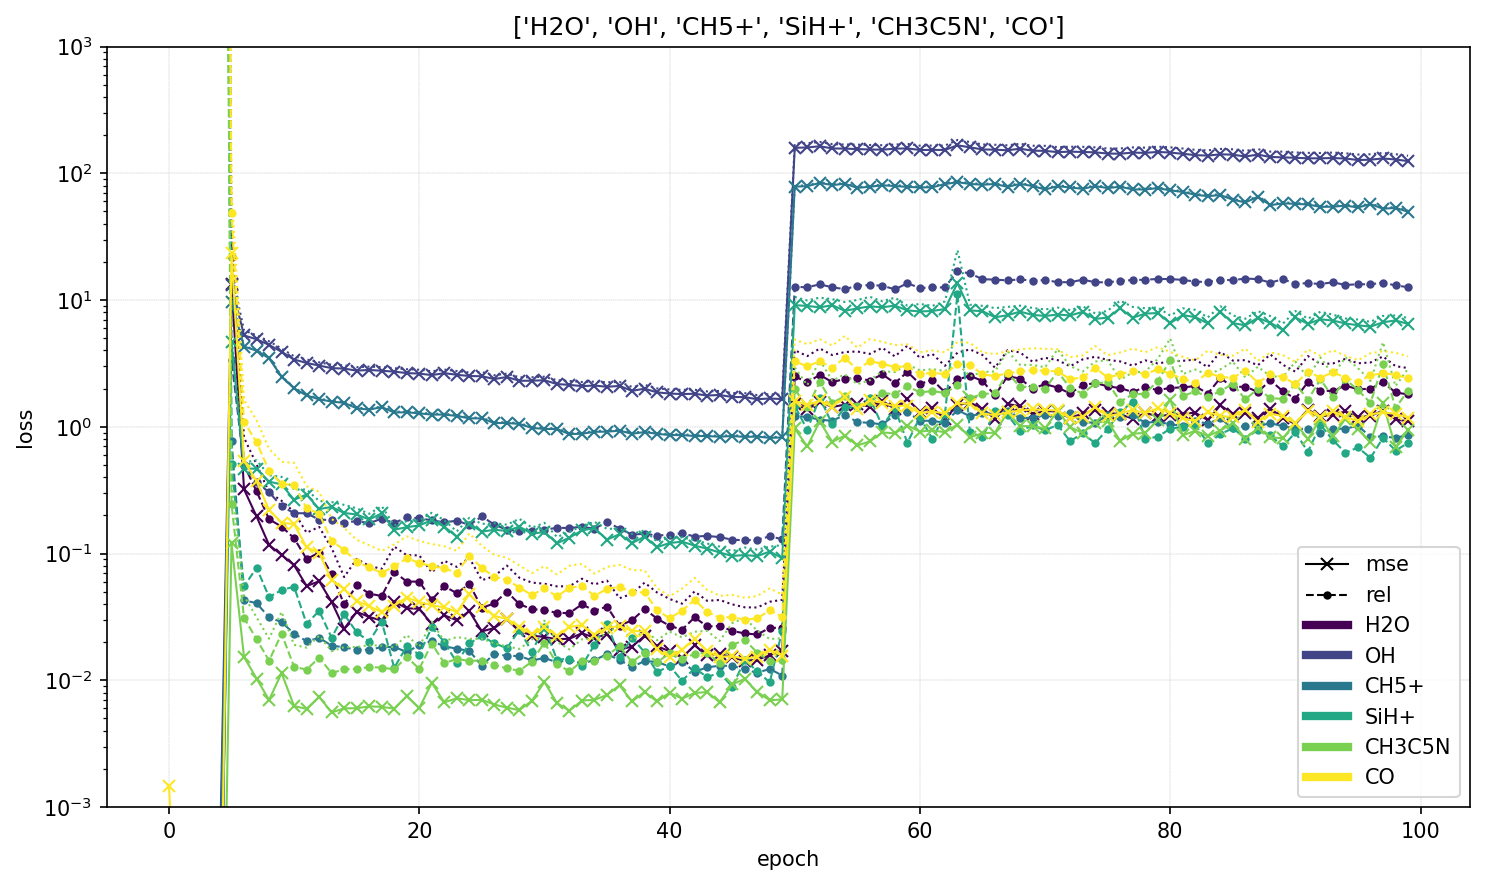

In [165]:
specs = ['H2O', 'OH', 'CH5+', 'SiH+','CH3C5N', 'CO']

fig = plot_loss_specs(trainloss, specs, log = True, ylim = True, limits=[1e-3,1e3])
plt.show()

### Test data set

In [7]:
def plot_compare(n, n_hat,ax1, color, alpha, title = None):
    cutoff = 1e-20
    nmin = np.log10(cutoff)
    nmax = np.log10(0.85e-1)

    x = unscale(np.linspace(0,1,100), nmin, nmax)

    n_un = unscale(n,nmin, nmax)
    nhat_un = unscale(n_hat,nmin, nmax).detach().numpy()

    # ax1.set_title(title)

    ms = 3

    i=-1
    # specs = ['H2O', 'CO','C2H2', 'C2H', 'HCN', 'CN','OH', 'CH5+', 'SiH+','CH3C5N']
    # for spec in specs:
    #     idx = specs_dict[spec]
    #     ax1.scatter(n_un[0][i][idx],nhat_un[0][i][idx],marker = 'o', alpha = alpha, label = spec) # type: ignore
    ax1.scatter(n_un[0][i],nhat_un[0][i],marker = 'o', color = color, alpha = alpha, label = title) # type: ignore

    ax1.plot(x,x, '--k', lw = 0.5)

    ax1.set_xlabel('real log abundance')
    ax1.set_ylabel('predicted log abundance')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(fontsize = 10)

    return

In [8]:
testdir = 'easy-mace2'
# testdir = 'C-short-dtime'

input, dataset, Chempy = ds.get_test_data(testdir, meta['dt_fract'])

1988
torch.Size([466, 24]) torch.Size([4]) torch.Size([24])


#### Final model

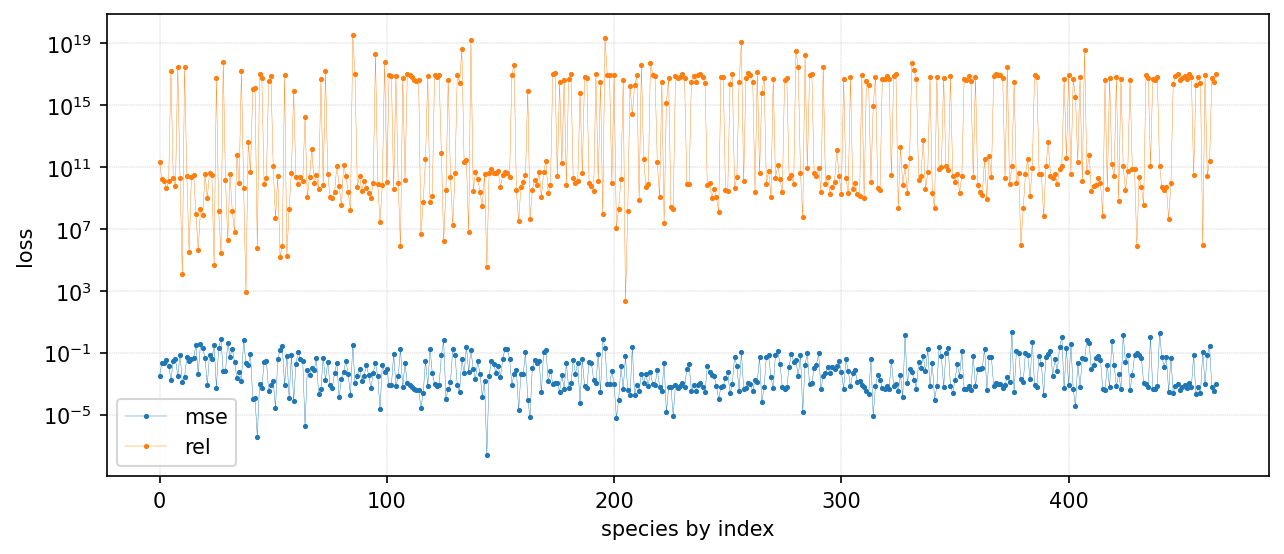

In [36]:
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot((111))

lw = 0.2
ms = 3

ax1.plot(idv_mse[0], ls = '-' , marker = '.' , label='mse' ,lw = lw, alpha = 1, ms = ms)
ax1.plot(idv_rel[0], ls = '-' , marker = '.' , label='rel' ,lw = lw, alpha = 1, ms = ms)

ax1.set_xlabel('species by index')
ax1.set_ylabel('loss')

ax1.set_yscale('log')
ax1.grid(True, linestyle = '--', linewidth = 0.2)


ax1.legend()
plt.show()

>>> Testing model...

Test loss       : 1.0535736196506583e+18

Solving time [s]: 0.0316314697265625


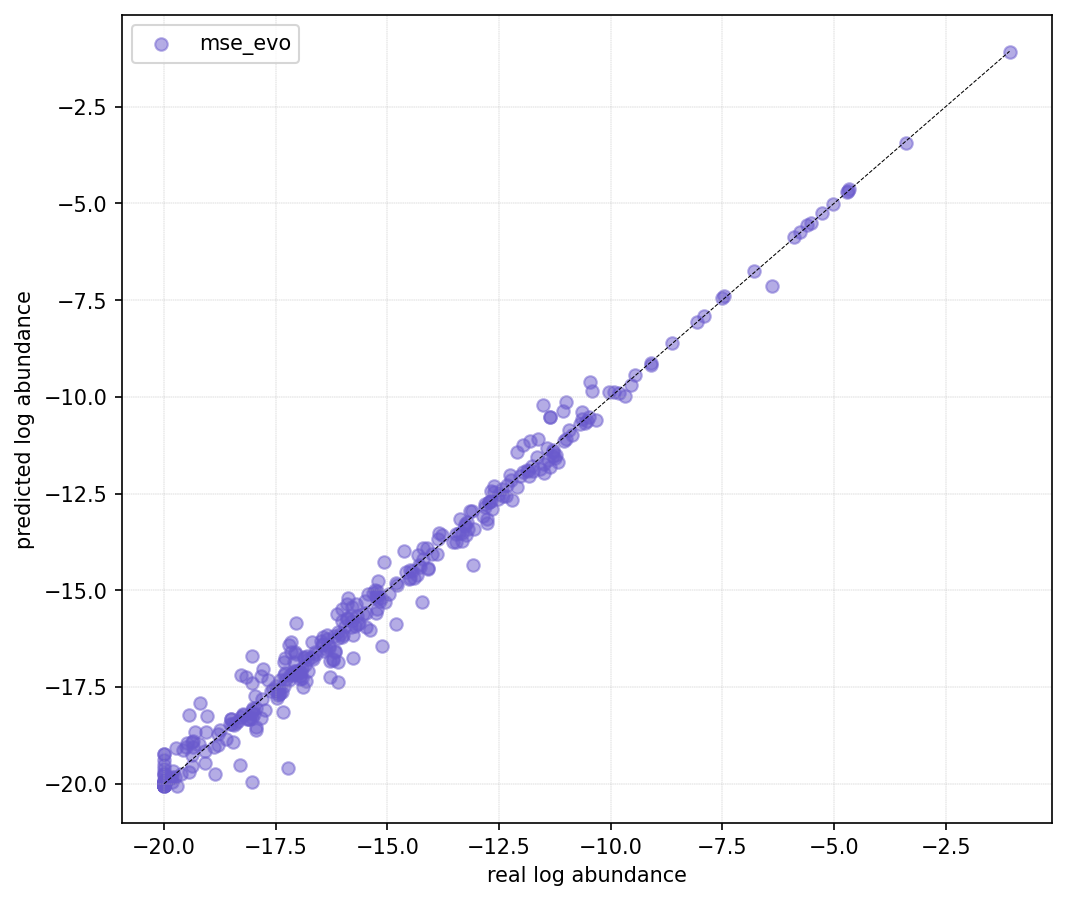

In [14]:
fig = plt.figure(figsize = (8,7))
ax1 = fig.add_subplot((111))
n, n_hat, t, loss,comptime = tr.test(model, input, testloss)
plot_compare(n, n_hat, ax1, 'slateblue', alpha = 0.5, title = testloss.type)

plt.show()

#### model evolution

>>> Testing model...

Test loss       : 8.455461857016949e+20

Solving time [s]: 0.006833791732788086
>>> Testing model...

Test loss       : 2.8093190592746488e+20

Solving time [s]: 0.006475687026977539
>>> Testing model...

Test loss       : 2.2881271501013857e+20

Solving time [s]: 0.006501436233520508
>>> Testing model...

Test loss       : 2.1606715862877313e+21

Solving time [s]: 0.008098602294921875
>>> Testing model...

Test loss       : 1.5191746332404272e+21

Solving time [s]: 0.006846904754638672
>>> Testing model...

Test loss       : 1.3198752908180288e+21

Solving time [s]: 0.0054645538330078125
>>> Testing model...

Test loss       : 7.774824401083145e+20

Solving time [s]: 0.005102396011352539
>>> Testing model...

Test loss       : 2.0577057880071597e+21

Solving time [s]: 0.014744281768798828
>>> Testing model...

Test loss       : 8.746747644040855e+20

Solving time [s]: 0.005601406097412109
>>> Testing model...

Test loss       : 2.1165550280254517e+21

Solving tim

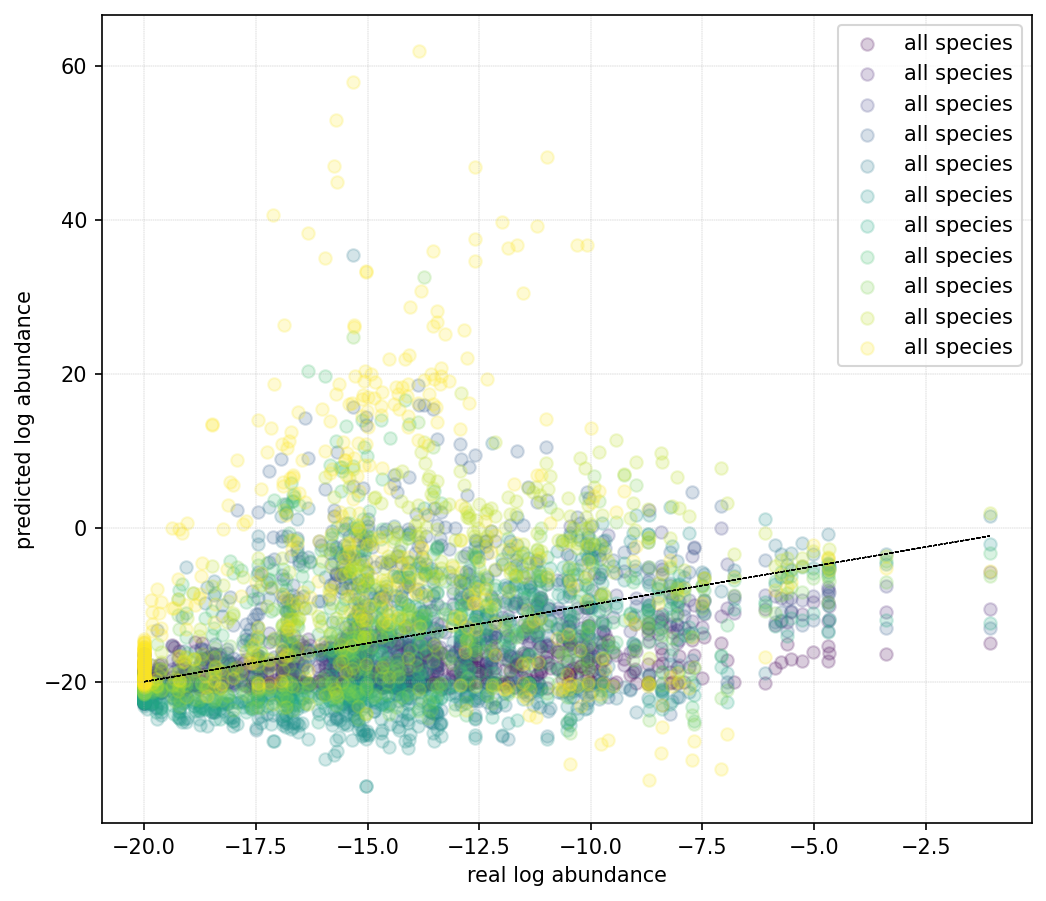

In [146]:
epochs = [0,1,2,3,4,5,10,11,12,13,14]

fig = plt.figure(figsize = (8,7))
ax1 = fig.add_subplot((111))

colors = mpl.cm.viridis(np.linspace(0, 1, len(epochs)))

for i,epoch in enumerate(epochs):
    model_i = load_model(outloc+dirname+'/', meta, epoch, True)
    n, n_hat, t, loss, idv_mse, idv_rel, comptime = tr.test(model_i, input, testloss)

    fig = plot_compare(n, n_hat,ax1, color = colors[i], alpha = 0.2)